In [1]:
import scanpy as sc
import anndata as ann
import loompy as lo
import numpy as np 
import glob
import seaborn as sb
import pandas as pd
import scrublet as scr
import pickle

sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '/storage/groups/ml01/workspace/karin.hrovatin/code/diabetes_analysis/')
import helper as h

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(scran)
library(RColorBrewer)
library(DropletUtils)
library(BiocParallel)

In [3]:
# Path for saving results - last shared folder by all datasets
shared_folder = '/dss/dsshome1/lxc07/gobi009/data/' + 'GSE114297/'
#Path for loading individual samples
path_data = '/dss/dsshome1/lxc07/gobi009/data/' + 'GSE114297/scanpy_AnnData/Donor_*/'

## Load data (filtered)

In [4]:
# Load metadata for the project
metadata = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='UPR')

In [5]:
# Find samples used for reference
samples = metadata.copy()
print('Selected samples:')
samples

Selected samples:


sample_name      GEO_ID  tissue  death_cause                design  \
0      Donor_1  GSM3138939  islets       anoxia      anoxia_32_female   
1      Donor_2  GSM3138940  islets       anoxia        anoxia_23_male   
2      Donor_3  GSM3138941  islets  head_trauma    headtrauma_52_male   
3      Donor_4  GSM3138942  islets       stroke        stroke_52_male   
4      Donor_5  GSM3138943  islets  head_trauma    headtrauma_49_male   
5      Donor_6  GSM3138944  islets       anoxia      anoxia_37_female   
6      Donor_7  GSM3138945  islets       stroke        stroke_39_male   
7      Donor_8  GSM3138946  islets       stroke        stroke_28_male   
8      Donor_9  GSM3138947  islets  head_trauma    headtrauma_49_male   
9     Donor_10  GSM3138948  islets  head_trauma  headtrauma_55_female   
10    Donor_11  GSM3138949  islets       stroke      stroke_49_female   
11    Donor_12  GSM3138950  islets       stroke        stroke_56_male   

    disease technique  weight   age         ethnicity     sex   BMI  HbA1c  \
0   healthy  Chromium    61.7  32 y         caucasian  female  24.9    5.3   
1   healthy  Chromium    73.9  23 y          hispanic    male  24.8    5.3   
2   healthy  Chromium    99.8  52 y         caucasian    male  30.0    5.4   
3   healthy  Chromium    78.5  52 y         caucasian    male  22.0    5.6   
4   healthy  Chromium    91.2  49 y         caucasian    male  26.5    5.1   
5   healthy  Chromium    64.0  37 y          hispanic  female  22.9    5.7   
6   healthy  Chromium    77.1  39 y         caucasian    male  23.6    4.5   
7   healthy  Chromium    99.8  28 y         caucasian    male  30.8    4.9   
8   healthy  Chromium    78.0  49 y         caucasian    male  26.2    5.2   
9   healthy  Chromium    68.5  55 y         caucasian  female  23.5    5.1   
10  healthy  Chromium    73.0  49 y  african_american  female  23.0    5.7   
11  healthy  Chromium    68.9  56 y         caucasian    male  21.2    5.4   

   organism  
0     human  
1     human  
2     human  
3     human  
4     human  
5     human  
6     human  
7     human  
8     human  
9     human  
10    human  
11    human

In [6]:
# List all files
file_name = 'filtered_feature_bc_matrix.h5ad'
files = glob.glob(path_data + file_name)
# print(path_data)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx = []
for position in range(len(path_data.split('/'))):
    values = set([file.split('/')[position] for file in files])
    # print(values)
    if len(values) > 1:
        diff_path_idx.append(position)

In [7]:
# Subset to files used for reference
files_subset = []
for file in files:
    sample = '_'.join([file.split('/')[i] for i in diff_path_idx])
    # print(sample)
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
# Subset only files that are contained in the xlsc sheet
print('Selected sample files:')
files_subset

Selected sample files:


['/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_2/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_7/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_3/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_4/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_10/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_1/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_8/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_9/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_5/filtered_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_12/filtered_fea

In [8]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas = []
file_diffs = []
for file in files_subset:
    print(f'Reading file {file}')
    adatas.append(sc.read_h5ad(file))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata = ann.AnnData.concatenate(*adatas,  batch_key='file', batch_categories=file_diffs).copy()

Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_2/filtered_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_7/filtered_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_3/filtered_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_4/filtered_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_10/filtered_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_1/filtered_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_8/filtered_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_9/filtered_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_5/filtered_feature_bc_matrix.h5ad


In [9]:
# Sample names
file_diffs

['Donor_2',
 'Donor_7',
 'Donor_3',
 'Donor_4',
 'Donor_10',
 'Donor_1',
 'Donor_8',
 'Donor_9',
 'Donor_5',
 'Donor_12',
 'Donor_6',
 'Donor_11']

In [10]:
adata

AnnData object with n_obs × n_vars = 28256 × 20611
    obs: 'file'

In [11]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs) == 1:
    adata.obs['file'] = file_diffs[0]

## Empty droplets and ambient gene expression

### Check that empty droplets were removed

N counts for cells that passed CellRanger filtering

In [12]:
# Visually check if empty cells are present
adata.obs['n_counts'] = adata.X.sum(axis = 1)

In [13]:
adata.obs['n_counts']

index
AAACGCTGTCCCAC-1-Donor_2     10710.0
AAACGCTGTCGTGA-1-Donor_2      5408.0
AAACGCTGTGGAAA-1-Donor_2     14253.0
AAACGGCTTTCCCG-1-Donor_2     13365.0
AAACTTGAAGCTCA-1-Donor_2      7836.0
                              ...   
TTTGACTGAGAGGC-1-Donor_11    11657.0
TTTGCATGCAAGCT-1-Donor_11     1589.0
TTTGCATGCTCCCA-1-Donor_11    11445.0
TTTGCATGTCCAAG-1-Donor_11     4405.0
TTTGCATGTTCGGA-1-Donor_11     6320.0
Name: n_counts, Length: 28256, dtype: float32

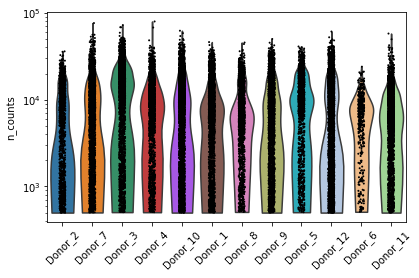

In [14]:
t1 = sc.pl.violin(adata, 'n_counts',
                  groupby='file',
                  size=2,
                  log=True,
                  cut=0,
                  rotation=45)

### NOTE
are the different locations of the high-count clusters caused by batch effect or genuine signal?

In [15]:
# Load raw data
# List all files
file_name='raw_feature_bc_matrix.h5ad'
files=glob.glob(path_data + file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx = []
for position in range(len(path_data.split('/'))):
    values = set([file.split('/')[position] for file in files])
    if len(values) > 1:
        diff_path_idx.append(position)

In [16]:
# Subset to files used for reference
files_subset = []
for file in files:
    sample = '_'.join([file.split('/')[i] for i in diff_path_idx])
    if any(sample_name in sample for sample_name in samples.sample_name.values):
        files_subset.append(file)
print('Selected sample files:')
files_subset

Selected sample files:


['/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_2/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_7/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_3/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_4/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_10/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_1/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_8/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_9/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_5/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_12/raw_feature_bc_matrix.h5ad',
 '/dss/dsshome1/lxc07/gobi00

In [17]:
# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas_raw = []
file_diffs = []
for file in files_subset:
    print(f'Reading file {file}')
    adatas_raw.append(sc.read_h5ad(file))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata_raw = ann.AnnData.concatenate(*adatas_raw,  batch_key='file', batch_categories=file_diffs).copy()   

Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_2/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_7/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_3/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_4/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_10/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_1/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_8/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_9/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data/GSE114297/scanpy_AnnData/Donor_5/raw_feature_bc_matrix.h5ad
Reading file /dss/dsshome1/lxc07/gobi009/data

In [18]:
adata_raw

AnnData object with n_obs × n_vars = 8847360 × 20611
    obs: 'file'

In [19]:
# Add file annotation if single sample is present so that below code works
if len(file_diffs) == 1:
    adata_raw.obs['file'] = file_diffs[0]

In [20]:
adata_raw.obs['n_counts'] = adata_raw.X.sum(1)

In [21]:
# Find drops removed by CellRanger
filtered_drops =~ adata_raw.obs.index.isin(adata.obs.index)
print(f'N drops filtered out as empty: {filtered_drops.sum()}/{adata_raw.shape[0]} -> remaining: {adata.shape[0]}')

N drops filtered out as empty: 8819104/8847360 -> remaining: 28256


Distribution of N counts of drops that were removed by CellRanger

Trying to set attribute `._uns` of view, copying.


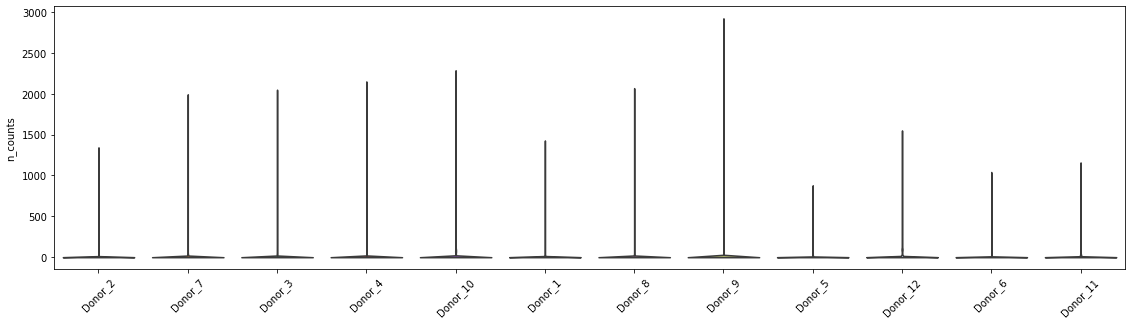

In [22]:
# Plot n_counts of drops that were removed by CellRanger
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_raw[filtered_drops], ['n_counts'], groupby='file', size=1, log=False, rotation=45, stripplot=False)

In [23]:
print('N cells per non-filtered sample')
adata_raw.obs['file'].value_counts()

N cells per non-filtered sample


Donor_2     737280
Donor_7     737280
Donor_3     737280
Donor_4     737280
Donor_10    737280
Donor_1     737280
Donor_8     737280
Donor_9     737280
Donor_5     737280
Donor_12    737280
Donor_6     737280
Donor_11    737280
Name: file, dtype: int64

In [24]:
# Remove empty genes and cells
sc.pp.filter_cells(adata_raw, min_counts=1)
sc.pp.filter_genes(adata_raw, min_cells=1)

filtered out 4516896 cells that have less than 1 counts
filtered out 2638 genes that are detected in less than 1 cells


In [25]:
adata_raw

AnnData object with n_obs × n_vars = 4330464 × 17973
    obs: 'file', 'n_counts'
    var: 'n_cells'

For CellBender (NOT NEEDED): Cell N counts sorted by cell N counts rank without all 0 cells.
NOTE: This cellbender plot is not needed.

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


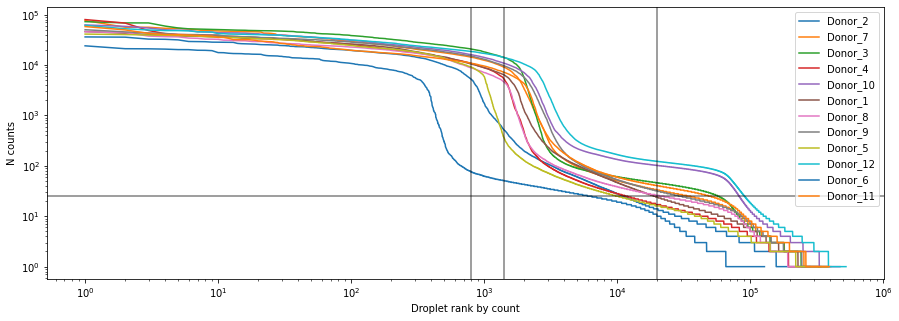

In [26]:
# For each file plot N count vs cell rank by count with log axes
fig, ax = plt.subplots()
for file in adata_raw.obs.file.unique():
    adata_raw_sub = adata_raw[adata_raw.obs.file == file, :].copy()
    plt.plot(list(range(1, adata_raw_sub.shape[0] + 1)), adata_raw_sub.obs.n_counts.sort_values(ascending=False), label=file)
del adata_raw_sub
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Droplet rank by count')
plt.ylabel('N counts')
ax.axvline(800,c='k',alpha=0.5)
ax.axvline(1400,c='k',alpha=0.5)
ax.axvline(20000,c='k',alpha=0.5)
ax.axhline(25,c='k',alpha=0.5)

### Compute ambient genes

Compute ambient genes with emptyDrops and based on mean expression in low count droplets across all samples.

In [27]:
# Prepare data for emptyDrops
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

NOTE: Takes some time - skip empty drops ande use manual below.

emptyDrops top ambient genes with scores.

NOTE: Use this instead as it is quicker and comparable for the top genes.

Genes with highest mean expression in empty droplets (n_counts < 100, similar to emptyDrops).

In [28]:
ambient_vars = ['mean_ambient_n_counts']
adata_raw.var['mean_ambient_n_counts'] = adata_raw[adata_raw.obs['n_counts'] < 100].X.mean(0).A1
adata_raw.var['mean_ambient_n_counts'].sort_values(ascending=False)[:20]

index
INS       1.490459
GCG       0.462934
TTR       0.228057
SST       0.150770
MT-CO1    0.136485
FTL       0.080020
REG1A     0.074766
MT-CO2    0.073946
MT-CO3    0.072430
FTH1      0.071442
PPY       0.048493
B2M       0.047286
MT-ND4    0.044752
EEF1A1    0.042320
RPL3      0.041332
TMSB4X    0.040548
RPL13A    0.036504
RPL41     0.034213
IAPP      0.033689
MT-CYB    0.033401
Name: mean_ambient_n_counts, dtype: float32

In [29]:
adata_raw

AnnData object with n_obs × n_vars = 4330464 × 17973
    obs: 'file', 'n_counts'
    var: 'n_cells', 'mean_ambient_n_counts'

The two gene lists are very similar for top genes.

Compute ambient genes for each sample based on mean expression in empty droplets.

In [30]:
# Mean empty expression in individual samples
#for file in adata_raw.obs.file.cat.categories:
#print(adata_raw.var)
for file in adata_raw.obs.file.unique():
    #print(file)
    adata_raw.var['mean_ambient_n_counts_' + file] = adata_raw[(adata_raw.obs.file == file) & (adata_raw.obs['n_counts'] < 100)].X.mean(0).A1
    #print(adata_raw.var['mean_ambient_n_counts_' + file])
    ambient_vars.append('mean_ambient_n_counts_' + file)
    
# Top genes in individual samples    
ambient_genes = set()
#for file in adata_raw.obs.file.cat.categories:
for file in adata_raw.obs.file.unique():
    ambient_file = list(adata_raw.var['mean_ambient_n_counts_' + file][np.flip(np.argsort(adata_raw.var['mean_ambient_n_counts_' + file]))].index)
    ambient_genes.update(ambient_file)

Mean ambient expression in individual samples divided by total mean ambient expression of individual samples. Ordered by combined smples, including top 20 ambient genes from each comparison.

In [31]:
# normalise ambient scores
ambient_df = adata_raw.var[ambient_vars]
ambient_df = ambient_df.loc[ambient_genes, ambient_vars] / ambient_df.sum(axis=0)

/gpfs/scratch/pn25xo/gobi009/gobi009/ipykernel_32814/2821544395.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ambient_df = ambient_df.loc[ambient_genes, ambient_vars] / ambient_df.sum(axis=0)


<AxesSubplot:ylabel='index'>

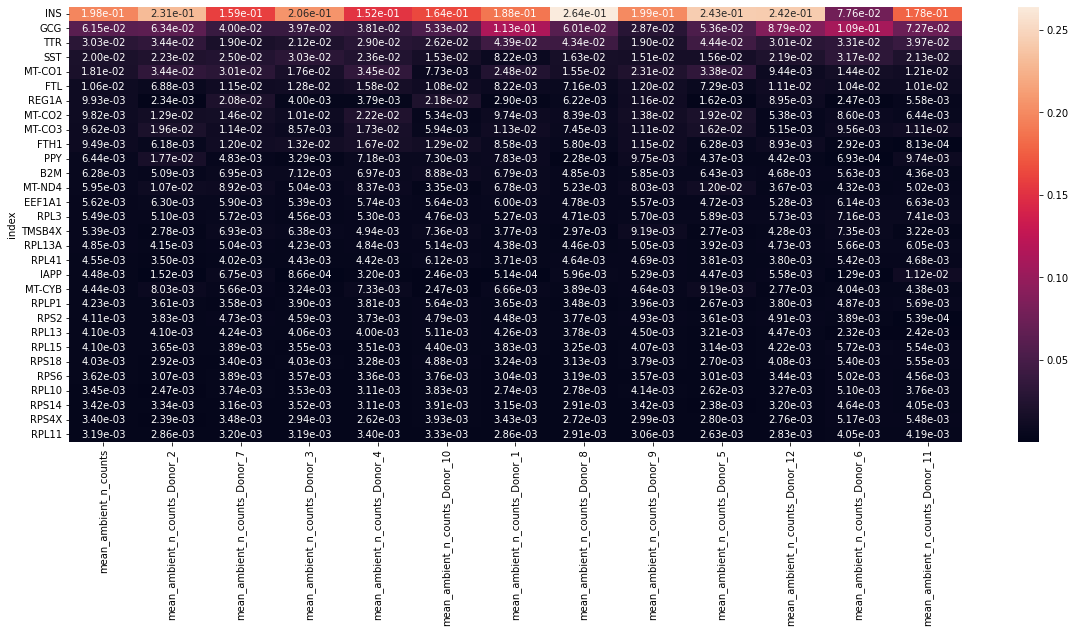

In [32]:
# Display ambient genes across samples
rcParams['figure.figsize'] = (20, 8)
sb.heatmap(ambient_df.sort_values('mean_ambient_n_counts', ascending=False).iloc[:30, :], annot=True, fmt='.2e')

In [33]:
# Save ambient DF for top N genes
ambient_df.to_csv(shared_folder + 'ambient_genes_top_N_scores.tsv',sep='\t')

In [34]:
# Save genes with scaled mean ambient expression at least > 0.005 in any sample - 
# use the same genes for each sample so that further processing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection = list(ambient_df[(ambient_df > 0.005).any(axis=1)].index)

print(f'Selected ambient genes: {ambient_genes_selection}')
pickle.dump(ambient_genes_selection, open(f'{shared_folder}ambient_genes_selection.pkl', 'wb'))
len(ambient_genes_selection)

Selected ambient genes: ['SST', 'MT-CO1', 'RPS6', 'RPL13A', 'MT-CO3', 'RBP4', 'RPLP1', 'RPL13', 'REG3A', 'REG1B', 'FTH1', 'TMSB4X', 'GCG', 'MT-CO2', 'MT-ND2', 'REG1A', 'B2M', 'EEF1A1', 'INS', 'PRSS2', 'TTR', 'RPS18', 'RPL15', 'RPL10', 'MT-ND4', 'PPY', 'RPL3', 'IAPP', 'RPS4X', 'RPL41', 'FTL', 'MT-CYB']


32

#### NOTE
Not really needed to do this longer ambient list.

Should we shorten it?

In [35]:
#### Proportion of ambience based on ambient threshold
#All calculations are based on removing ambient genes from single sample, except for the plot line 
#"N removed genes across samples" that represents N removed genes at threshold across all samples

In [36]:
# Calculate retained ambient proportion and sum(abs(ambient_mean_geneI-ambient_sample_geneI))
# for ambient gene removal thresholds. Ambient genes are removed per sample.
thresholds = list(1 / np.logspace(1, 18, num=300, base=2, dtype='int'))
ambient_diffs = pd.DataFrame(columns=adata_raw.obs.file.unique())
removed_genes = pd.DataFrame(columns=list(adata_raw.obs.file.unique()) + ['all'])
ambient_proportions = pd.DataFrame(columns=adata_raw.obs.file.unique())
for idx, threshold in enumerate(thresholds):
    ambient_df_sub = ambient_df[(ambient_df <= threshold).any(axis=1)]
    removed_genes.at[idx, 'all'] = adata_raw.shape[1] - ambient_df_sub.shape[0]
    for sample in adata_raw.obs.file.unique():
        ambient_df_sub = ambient_df[(ambient_df['mean_ambient_n_counts_' + sample] <= threshold)]
        removed_genes.at[idx, sample] = adata_raw.shape[1] - ambient_df_sub.shape[0]
        diff = abs(ambient_df_sub['mean_ambient_n_counts'] - ambient_df_sub['mean_ambient_n_counts_' + sample]).sum()
        ambient_diffs.at[idx, sample] = diff
        ambient_proportions.at[idx, sample] = ambient_df_sub['mean_ambient_n_counts_' + sample].sum()

In [37]:
AMBIENT_THR=0.0025 # chosen by visual inspection

In [38]:
#Difference between mean and per sample ambient scores for retained genes and N removed genes across samples

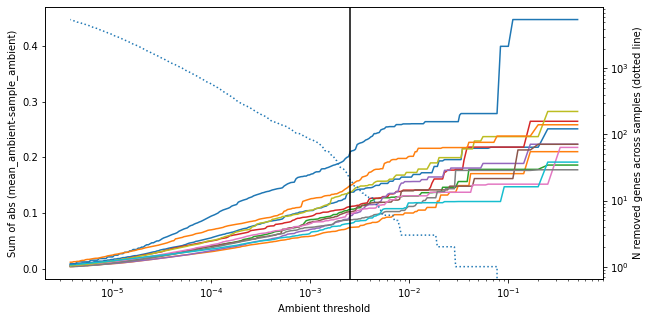

In [39]:
# Difference to average ambient scores for retained genes at each threshold
rcParams['figure.figsize'] = (10,5)
fig, ax = plt.subplots()
ax2 = ax.twinx()  
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds, ambient_diffs[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of abs (mean_ambient-sample_ambient)')
ax.set_xlabel('Ambient threshold')
ax2.plot(thresholds, removed_genes['all'], linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR, c='k')

In [40]:
#Retained ambient proportion per sample and N removed genes across samples

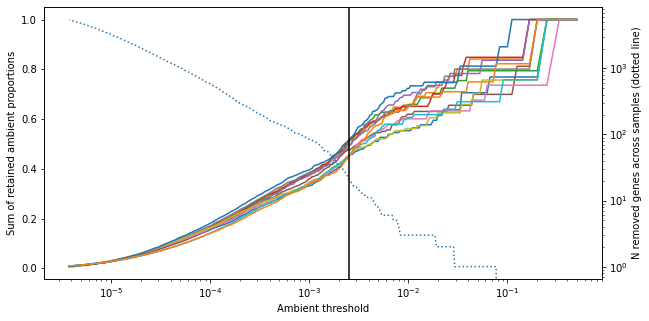

In [41]:
# Retained ambience per sample vs threshold
rcParams['figure.figsize'] = (10,5)
fig, ax = plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds, ambient_proportions[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of retained ambient proportions')
ax.set_xlabel('Ambient threshold')
ax2 = ax.twinx()  
ax2.plot(thresholds, removed_genes['all'], linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR, c='k')

In [42]:
#N removed genes per sample

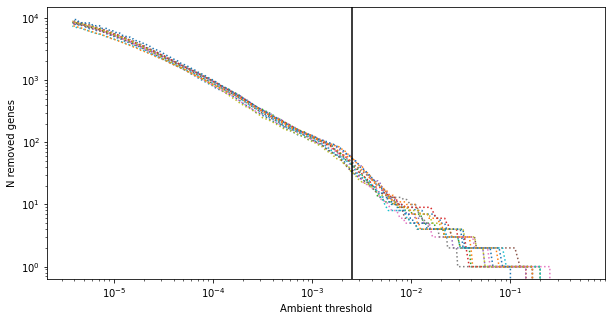

In [43]:
# N removed genes per sample
rcParams['figure.figsize'] = (10,5)
fig, ax = plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds, removed_genes[sample], linestyle='dotted')
ax.set_xscale('log')
ax.set_ylabel('N removed genes')
ax.set_xlabel('Ambient threshold')
ax.set_yscale('log')
plt.axvline(AMBIENT_THR, c='k')

In [44]:
#Removed ambience proportion divided by removed genes per sample

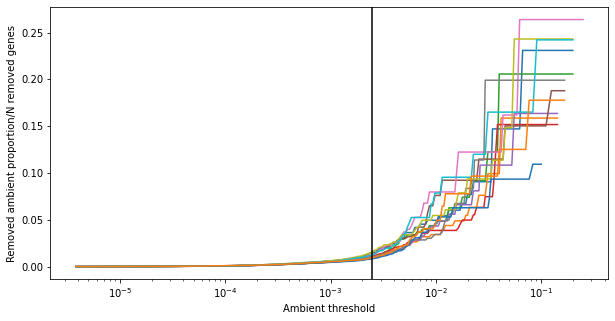

In [45]:
# Comparison of removed ambience vs N of removed genes per sample
rcParams['figure.figsize'] = (10,5)
fig, ax = plt.subplots()
for sample in adata_raw.obs.file.unique():
    any_removed = np.array(removed_genes[sample]) > 0
    ax.plot(np.array(thresholds)[any_removed], ((1 - ambient_proportions[sample]) / removed_genes[sample])[any_removed])
ax.set_xscale('log')
ax.set_ylabel('Removed ambient proportion/N removed genes')
ax.set_xlabel('Ambient threshold')
plt.axvline(AMBIENT_THR, c='k')

In [46]:
# Save genes with scaled mean ambient expression at least > threshold in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection = list(ambient_df[(ambient_df > AMBIENT_THR).any(axis=1)].index)

print(f'N selected ambient genes: {len(ambient_genes_selection)}')
pickle.dump(ambient_genes_selection, open(f'{shared_folder}ambient_genes_selection_extended.pkl', 'wb'))

N selected ambient genes: 78


In [47]:
del adata_raw

## QC (counts, genes, mt)

In [48]:
# Add other QC metrics

#adata.obs['n_counts'] = adata.X.sum(axis = 1)
#adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)

mt_gene_mask = np.flatnonzero([gene.startswith('MT-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1 / adata.obs['n_counts']

### QC on UMAP 
Data used for UMAP: Total count normalised data with log transformation and PC preprocessing. UMAP distances are based on correlation.

In [49]:
# Preprocess data for UMAP
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ZNHIT6', 'HSPA6', 'RPS27A', 'REG1B', 'REG1A', 'REG3A', 'RNF181', 'GCG', 'GHRL', 'MTRNR2L12', 'CPB1', 'SST', 'RPL9', 'IGFBP7', 'CXCL8', 'SPP1', 'SPINK1', 'SQSTM1', 'RACK1', 'HSPA1A', 'RPS18', 'CLPS', 'EEF1A1', 'VIP', 'NPY', 'HSPB1', 'COL1A2', 'PRSS1', 'PRSS2', 'TMSB4X', 'TIMP1', 'MTRNR2L10', 'RPS4X', 'HSPA5', 'INS', 'MTRNR2L8', 'FTH1', 'MMP7', 'RBP4', 'IAPP', 'RPLP0', 'DYNLL1', 'SERPINA1', 'SCG5', 'B2M', 'RPLP1', 'TPSB2', 'TPSAB1', 'RPS2', 'MT2A', 'MT1G', 'CTRB2', 'CTRB1', 'UBB', 'MTRNR2L1', 'CCL2', 'KRTAP3-2', 'PPY', 'COL1A1', 'TTR', 'CHGB', 'FTL', 'RPL3', 'MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND4', 'MT-CYB']
    finished (0:00:00)


computing PCA
    with n_comps=15
    finished (0:00:06)


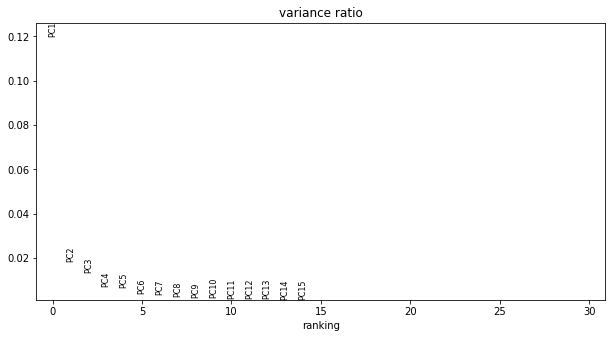

In [50]:
# Select number of PCs to use for UMAP
sc.pp.pca(adata_pp,n_comps=15, use_highly_variable=False)
sc.pl.pca_variance_ratio(adata_pp)

In [51]:
# Compute UMAP
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=6, metric='correlation')
sc.tl.umap(adata_pp)

computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


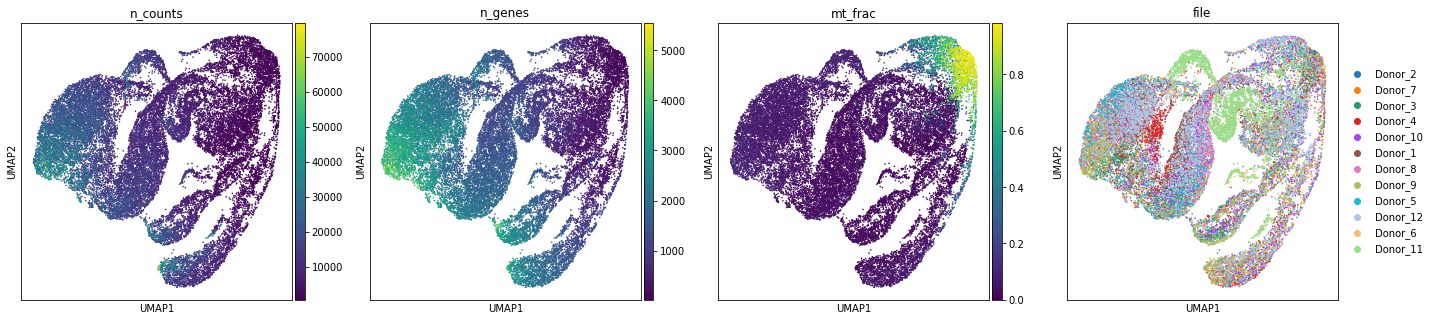

In [52]:
# Plot UMAP
rcParams['figure.figsize'] = (5, 5)
sc.pl.umap(adata_pp, color=['n_counts', 'n_genes', 'mt_frac', 'file'], size=10)

There is a subset of low counts and low genes cells that have high mt_fraction. Not all low count/gene cells have high mt fraction.

### QC - select thresholds

Check:
- joint distribution of N genes, N counts, and mt fraction
- distribution of metrics across samples

In [53]:
COUNTS_THR_MIN = 2000
COUNTS_THR_MAX = 45000

In [54]:
GENES_THR_MIN = 800
GENES_THR_MAX = 4600

In [55]:
MT_THR = 0.2

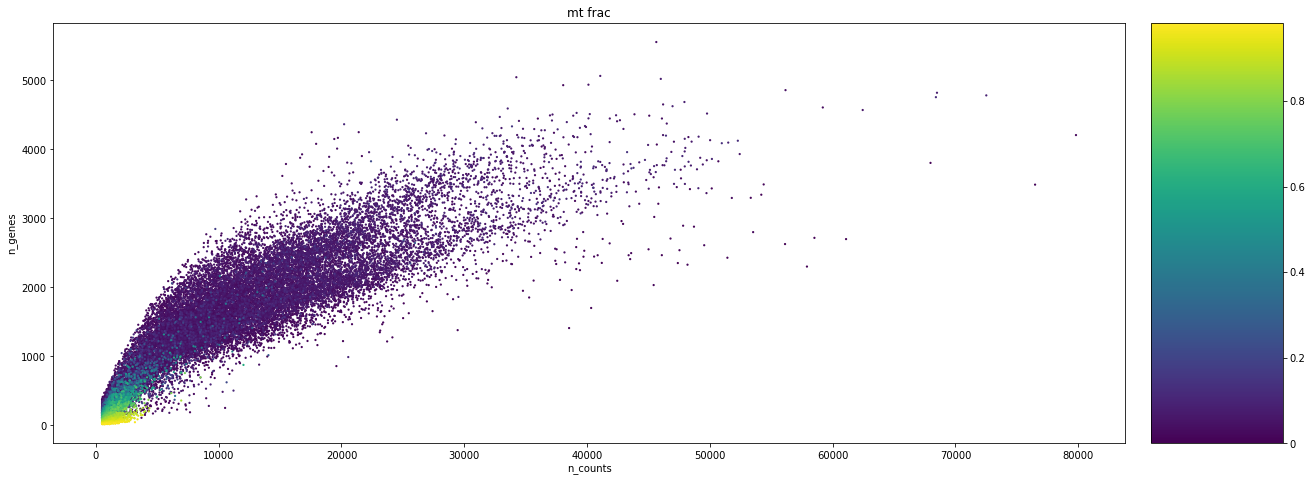

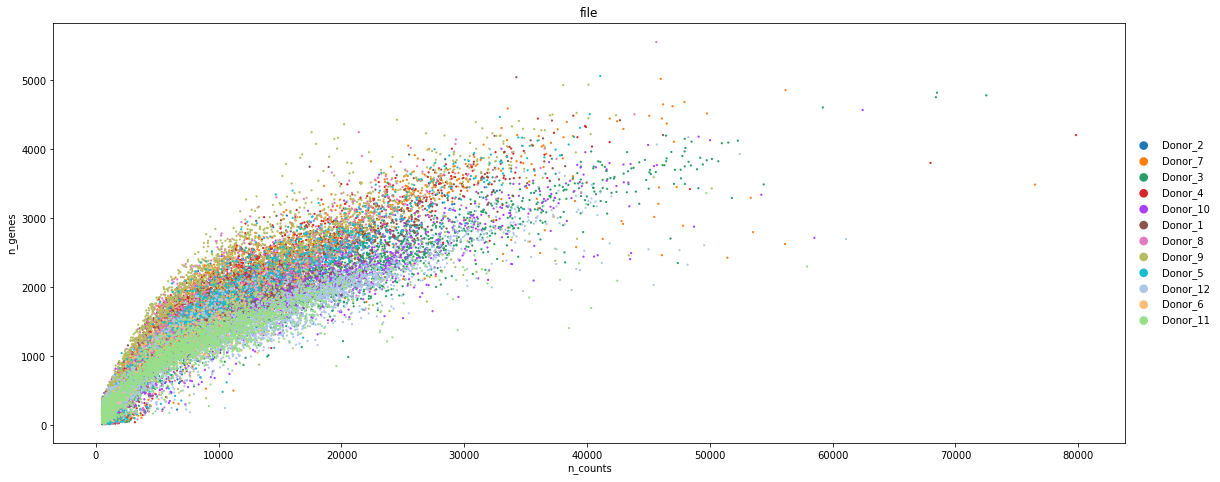

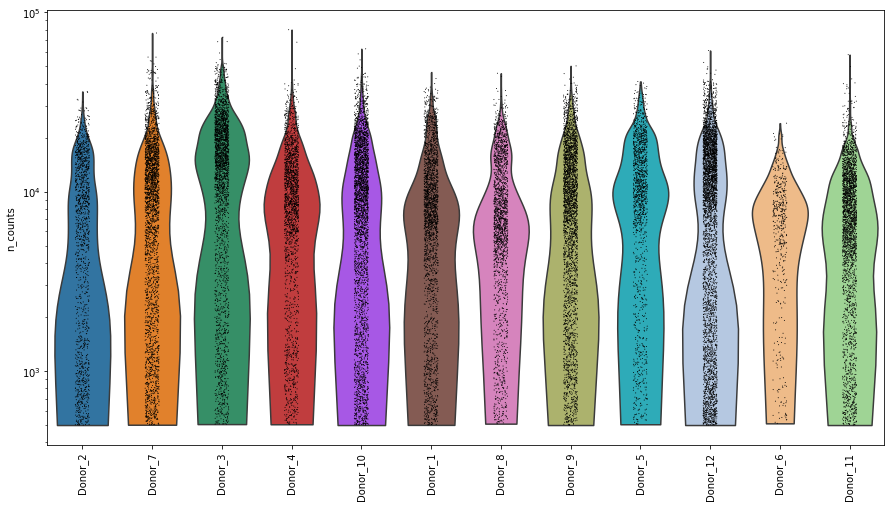

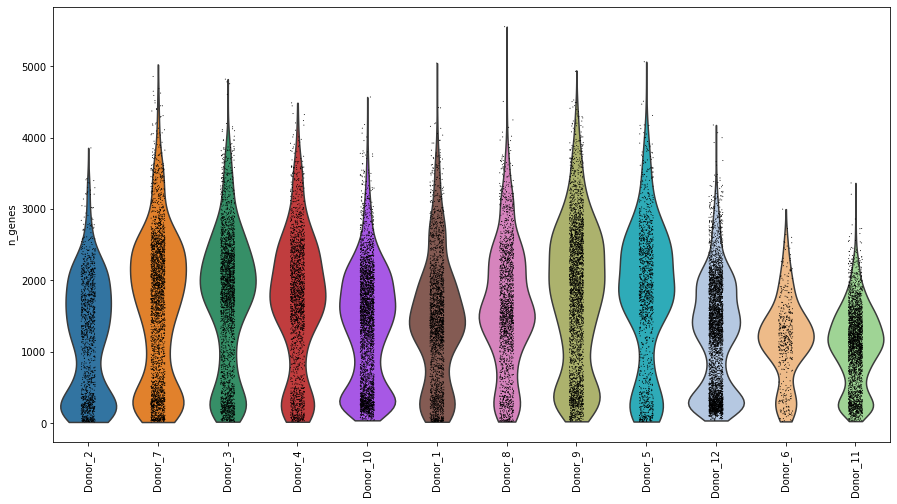

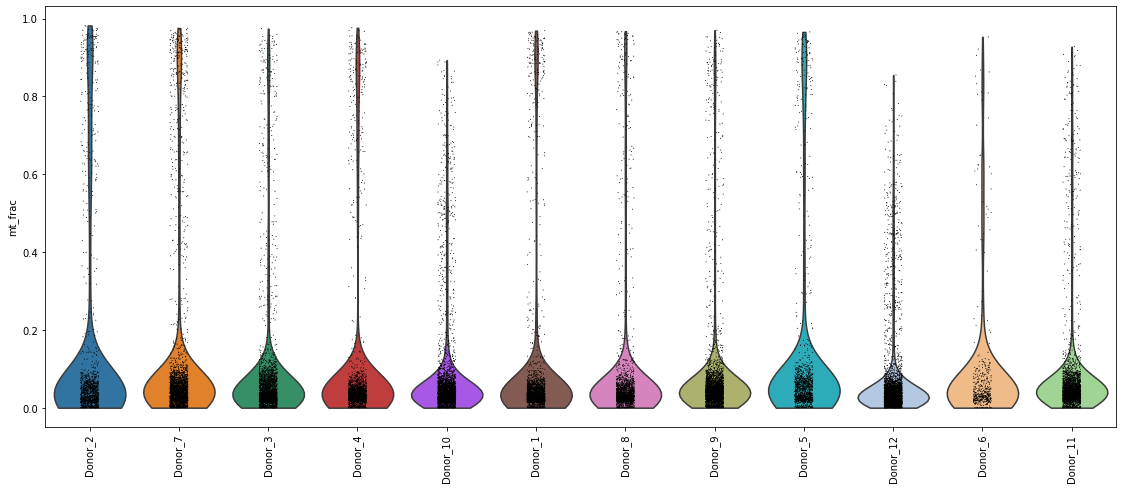

In [56]:
#Data quality summary plots
rcParams['figure.figsize'] = (15, 8)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=20)
random_indices = np.random.permutation(list(range(adata.shape[0])))
p1 = sc.pl.scatter(adata[random_indices, :], 'n_counts', 'n_genes', color='file', size=20)

fig, ax = plt.subplots()
sc.pl.violin(adata, ['n_counts'], groupby='file', size=1, log=True, rotation=90, ax=ax, show=False)

fig,ax = plt.subplots()
sc.pl.violin(adata, ['n_genes'], groupby='file', size=1, log=False, rotation=90, ax=ax, show=False)
sc.pl.violin(adata, ['mt_frac'], groupby='file', size=1, log=False, rotation=90)

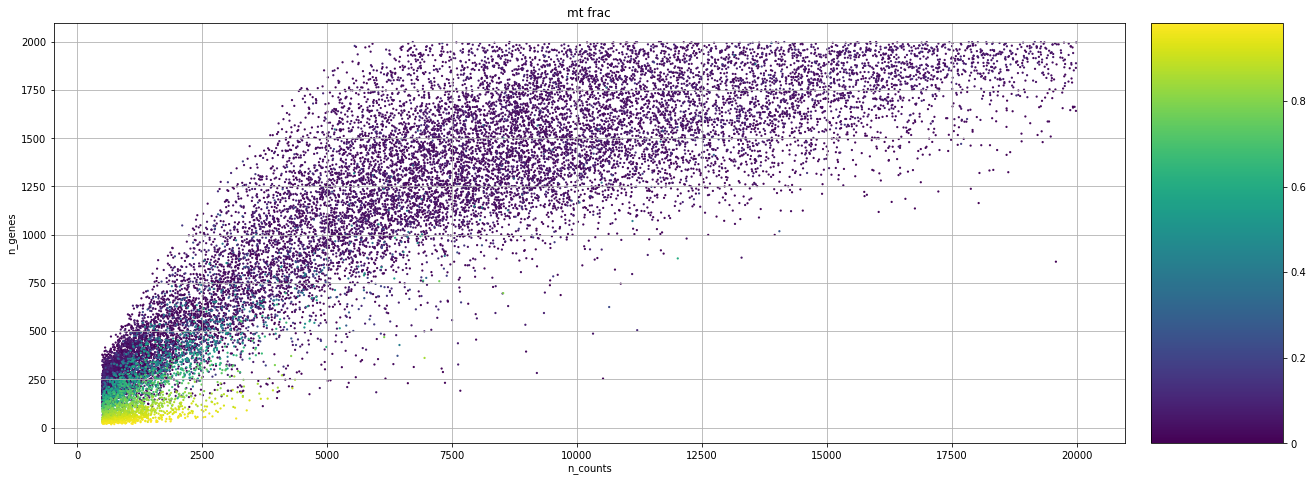

In [57]:
rcParams['figure.figsize'] = (15, 8)
p1 = sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes'] < 2000, adata.obs['n_counts'] < 20000)], 'n_counts', 'n_genes', color='mt_frac', size=20, show=False)
p1.grid()
plt.show()

N counts:

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


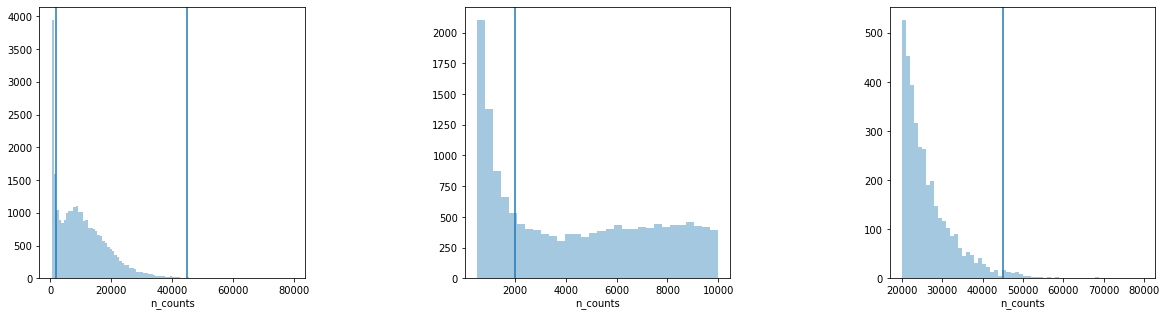

In [58]:
rcParams['figure.figsize'] = (20, 5)
fig_ind = np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

# Plot whole data
p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]),
                 bins=100)
p3.axvline(COUNTS_THR_MIN)
p3.axvline(COUNTS_THR_MAX)

# Plot beginning
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts'] < 10000], 
                 kde=False,
                 bins=30, 
                 ax=fig.add_subplot(fig_ind[1]))
p4.axvline(COUNTS_THR_MIN)

# Plot tail
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts'] > 20000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
p5.axvline(COUNTS_THR_MAX)

plt.show()

N genes:

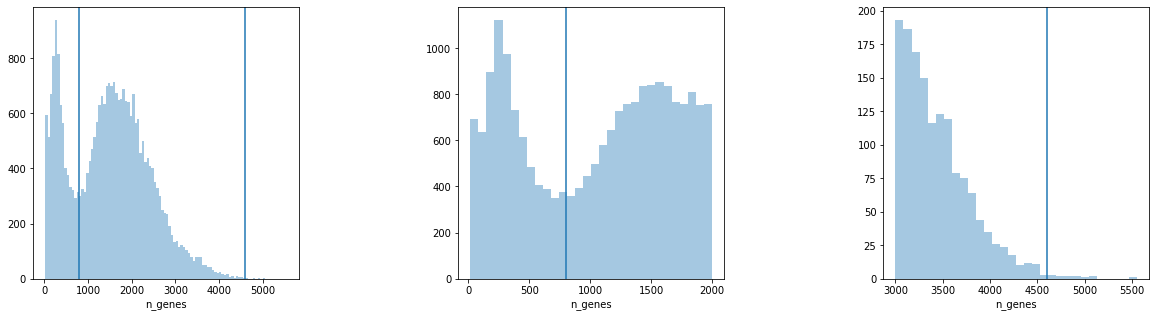

In [59]:
rcParams['figure.figsize'] = (20, 5)
fig_ind = np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

# Plot whole data
p6 = sb.distplot(adata.obs['n_genes'],
                 kde=False,
                 bins=100,
                 ax=fig.add_subplot(fig_ind[0]))
p6.axvline(GENES_THR_MIN)
p6.axvline(GENES_THR_MAX)

# Plot beginning
p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes'] < 2000], 
                 kde=False,
                 bins=30,
                 ax=fig.add_subplot(fig_ind[1]))
p7.axvline(GENES_THR_MIN)

# Plot tail
p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes'] > 3000], 
                 kde=False,
                 bins=30,
                 ax=fig.add_subplot(fig_ind[2]))
p8.axvline(GENES_THR_MAX)

plt.show()

MT fraction:

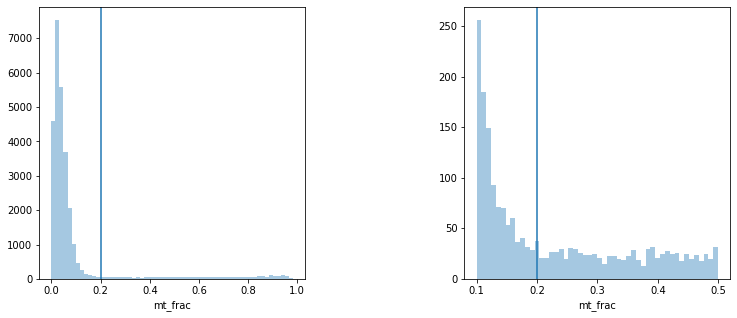

In [60]:
rcParams['figure.figsize'] = (20, 5)
fig_ind = np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'],
                 kde=False,
                 bins=60,
                 ax=fig.add_subplot(fig_ind[0]))
p8.axvline(MT_THR)

p9 = sb.distplot(adata.obs['mt_frac'][(adata.obs['mt_frac'] < 0.5).values & (adata.obs['mt_frac'] > 0.1).values], 
                 kde=False,
                 bins=50,
                 ax=fig.add_subplot(fig_ind[1]))
p9.axvline(MT_THR)

plt.show()

For cells that have too low/high metrics show location on UMAP.

In [61]:
def assign_high_low(adata, obs_col, low,high):
    """
    Add low/high annotation to each cell for a metric. 
    Add obs column specifying if cell has ok/low/high value (categories ordered in this order) and uns color map - 
    gray for ok, blue for low, red for high.
    New obs columns is named obs_col_filter and colourmap is named obs_col_filter_colors.
    :param adata: anndata object that contains column with metric to be filtered and to which filter result column
    and colur map are added
    :param obs_col: obs column on which to perform filtering
    :param low: low - cells that have obs_col value < low are assigned 'low'
    :param high: high - cells that have obs_col value > high are assigned 'high'
    """
    cell_type = []
    for val in adata.obs[obs_col]:
        if val > high:
            cell_type.append('high')
        elif val < low:
            cell_type.append('low')
        else:
            cell_type.append('ok')
    adata.obs[obs_col + '_filter']=cell_type
    adata.obs[obs_col + '_filter']=adata.obs[obs_col+'_filter'].astype('category')
    # So that low and high are plotted on top
    adata.obs[obs_col + '_filter'].cat.reorder_categories(
        [category for category in ['ok', 'low', 'high'] if category in adata.obs[obs_col + '_filter'].cat.categories], inplace=True)
    type_col = {'high': '#e62e0e','low': '#02c6ed','ok': '#a8a8a8'}
    col_list = []
    for filter_type in adata.obs[obs_col + '_filter'].cat.categories:
        col_list.append(type_col[filter_type])
    adata.uns[obs_col + '_filter_colors'] = col_list

/gpfs/scratch/pn25xo/gobi009/gobi009/ipykernel_32814/1574155549.py:24: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs[obs_col + '_filter'].cat.reorder_categories(


ok      22750
low      5417
high       89
Name: n_counts_filter, dtype: int64


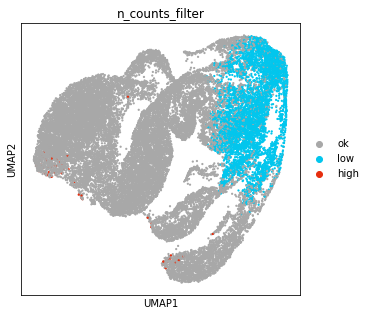

In [62]:
param = 'n_counts'
rcParams['figure.figsize'] = (5, 5)
#COUNTS_THR_MIN = 2000
#COUNTS_THR_MAX = 45000
assign_high_low(adata=adata, obs_col=param, low=COUNTS_THR_MIN, high=COUNTS_THR_MAX)
print(adata.obs[param + '_filter'].value_counts())
adata_pp.obs[param + '_filter'] = adata.obs[param + '_filter']
adata_pp.uns[param + '_filter_colors'] = adata.uns[param + '_filter_colors']
sc.pl.umap(adata_pp, color=[param + '_filter'], size=20)

/gpfs/scratch/pn25xo/gobi009/gobi009/ipykernel_32814/1574155549.py:24: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs[obs_col + '_filter'].cat.reorder_categories(


ok      20623
low      7619
high       14
Name: n_genes_filter, dtype: int64


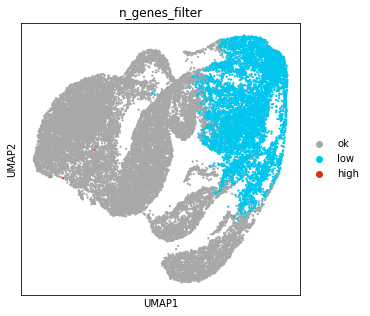

In [63]:
param = 'n_genes'
rcParams['figure.figsize'] = (5, 5)
#GENES_THR_MIN = 800
#GENES_THR_MAX = 4600
assign_high_low(adata=adata, obs_col=param, low=GENES_THR_MIN, high=GENES_THR_MAX)
print(adata.obs[param + '_filter'].value_counts())
adata_pp.obs[param + '_filter'] = adata.obs[param + '_filter']
adata_pp.uns[param + '_filter_colors'] = adata.uns[param + '_filter_colors']
sc.pl.umap(adata_pp, color = [param + '_filter'], size=20)

/gpfs/scratch/pn25xo/gobi009/gobi009/ipykernel_32814/1574155549.py:24: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs[obs_col + '_filter'].cat.reorder_categories(


ok      25569
high     2687
Name: mt_frac_filter, dtype: int64


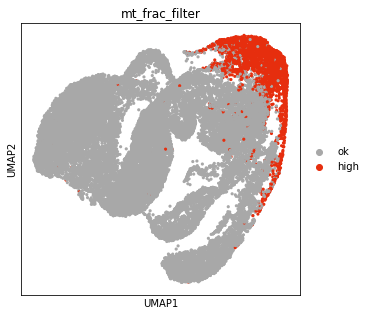

In [64]:
param = 'mt_frac'
#MT_THR = 0.2
rcParams['figure.figsize'] = (5, 5)
assign_high_low(adata=adata, obs_col=param, low=-1, high=MT_THR)
print(adata.obs[param+'_filter'].value_counts())
adata_pp.obs[param + '_filter'] = adata.obs[param + '_filter']
adata_pp.uns[param + '_filter_colors'] = adata.uns[param + '_filter_colors']
sc.pl.umap(adata_pp, color=[param + '_filter'], size=40)

High N cells and N gene outliers will be filtered out as well. Min counts will not be used for filtering as it is unclear where to put a threshold - mt and gene filtering will as it seems also remove these cells. 

N cells in which a gene is expressed:

In [65]:
adata.var['n_cells'] = (adata.X > 0).sum(axis=0).T

In [66]:
CELLS_THR_MIN = 20

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


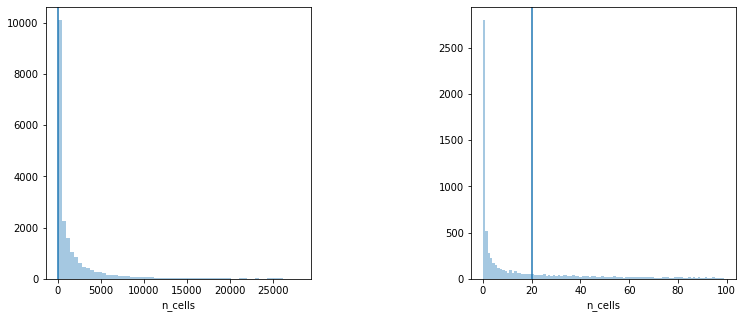

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='n_cells'>

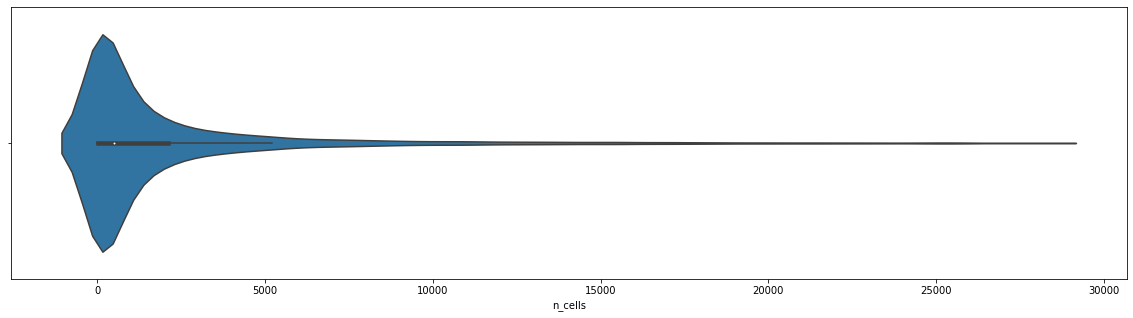

In [67]:
rcParams['figure.figsize'] = (20,5)
fig_ind = np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

# Plot whole data
p6 = sb.distplot(adata.var['n_cells'],
                 kde=False,
                 bins=60,
                 ax=fig.add_subplot(fig_ind[0]))
p6.axvline(CELLS_THR_MIN)

# Plot beginning
p8 = sb.distplot(adata.var['n_cells'][adata.var['n_cells'] < 100], 
                 kde=False,
                 bins=100,
                 ax=fig.add_subplot(fig_ind[1]))
p8.axvline(CELLS_THR_MIN)

plt.show()
sb.violinplot(adata.var['n_cells'])

Filter out genes and cells.

NOTE: If can not set a sensible threshold for one fo the m maybe dfo not use it.

In [68]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts=COUNTS_THR_MIN)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_counts=COUNTS_THR_MAX)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] <= MT_THR]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes=GENES_THR_MIN)
print('Number of cells after min gene filter: {:d}'.format(adata.n_obs))
sc.pp.filter_cells(adata, max_genes=GENES_THR_MAX)
print('Number of cells after max gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 28256
filtered out 5417 cells that have less than 2000 counts
Number of cells after min count filter: 22839
filtered out 89 cells that have more than 45000 counts
Number of cells after max count filter: 22750
Number of cells after MT filter: 21996
filtered out 1618 cells that have less than 800 genes expressed


Trying to set attribute `.obs` of view, copying.


Number of cells after min gene filter: 20378
filtered out 4 cells that have more than 4600 genes expressed
Number of cells after max gene filter: 20374


In [69]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))


# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=CELLS_THR_MIN)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 20611
filtered out 5319 genes that are detected in less than 20 cells
Number of genes after cell filter: 15292


Subset genes so that ref genes are not removed - UNUSED - insetad of the above cell

#### NOTE
We are not quite sure if 20 is appropriate, but the paper gives it as an example value.

## Doublet filtering

Perform doublet filtering with Scrublet per sample.

In [70]:
adata.obs['doublet_score'] = np.zeros(adata.shape[0])
adata.obs['doublet'] = np.zeros(adata.shape[0])

# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.05 
sim_doublet_ratio = 2
n_neighbors = None #If `None`, this is set to round(0.5 * sqrt(n_cells))

# Detect doublets per sample
for batch in adata.obs['file'].cat.categories:
    idx = adata.obs[adata.obs['file'] == batch].index
    print(batch, 'N cells:',idx.shape[0])
    scrub = scr.Scrublet(counts_matrix = adata[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts=min_counts, 
                    min_cells=min_cells, 
                    n_prin_comps=n_pc,
                    use_approx_neighbors=True, 
                    get_doublet_neighbor_parents=False)
    adata.obs.loc[idx,'doublet_score'] = doublet_scores
    adata.obs.loc[idx,'doublet'] = predicted_doublets

Donor_2 N cells: 854
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.23
Detected doublet rate = 5.3%
Estimated detectable doublet fraction = 36.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 14.6%
Elapsed time: 1.0 seconds
Donor_7 N cells: 1969
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.37
Detected doublet rate = 0.9%
Estimated detectable doublet fraction = 31.3%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 2.9%
Elapsed time: 2.2 seconds
Donor_3 N cells: 1954
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.22
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 54.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.

Distribution of doublet scores

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


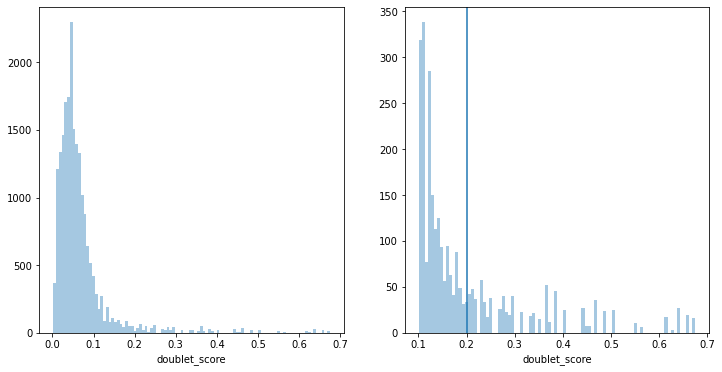

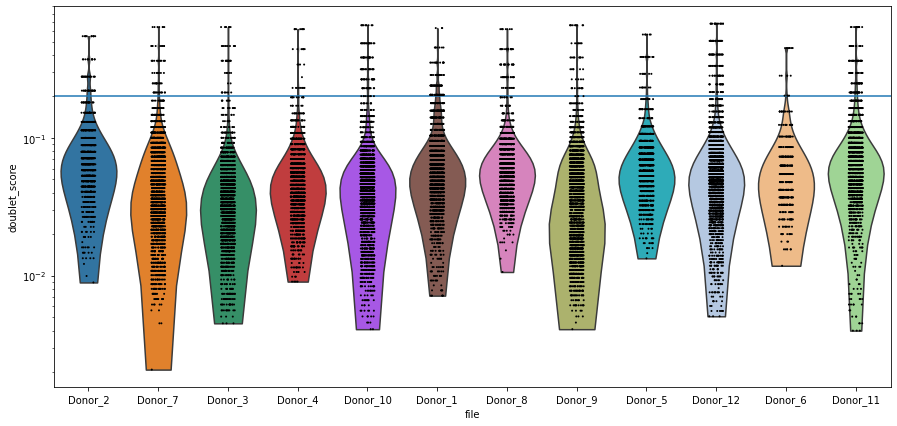

In [71]:
rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots(1, 2)
# Plot whole data
sb.distplot(adata.obs['doublet_score'],
            bins=100,
            kde=False,
            ax=ax[0])
# Plot tail
sb.distplot(adata[adata.obs.doublet_score > 0.1].obs['doublet_score'],
            bins=90,
            kde=False,
            ax=ax[1])

DOUBLET_THR = 0.2
ax[1].axvline(DOUBLET_THR)
plt.show()

rcParams['figure.figsize'] = (15, 7)
fig, ax = plt.subplots()
sc.pl.violin(adata, 'doublet_score',
             groupby='file',
             size=2,
             log=True,
             cut=0,
             ax=ax,
             show=False)
ax.axhline(DOUBLET_THR)
plt.show()

Trying to set attribute `.obs` of view, copying.


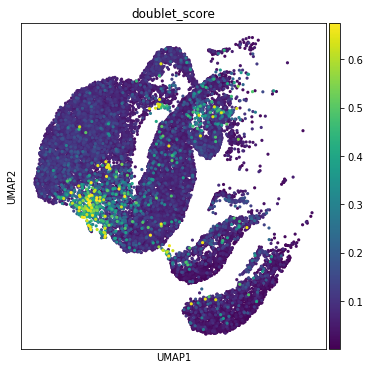

/gpfs/scratch/pn25xo/gobi009/gobi009/ipykernel_32814/1574155549.py:24: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata.obs[obs_col + '_filter'].cat.reorder_categories(


ok      19499
high      875
Name: doublet_score_filter, dtype: int64


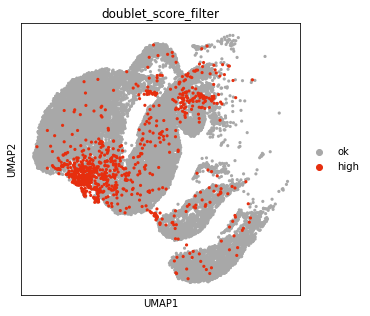

In [72]:
# Remove cells from adata_pp that were removed before from adata
adata_pp = adata_pp[adata.obs.index]

# Plot doublet score and filtering threshold on UMAP
rcParams['figure.figsize'] = (6,6)
adata_pp.obs['doublet_score'] = adata.obs['doublet_score']
sc.pl.umap(adata_pp, color=['doublet_score'], size=40)
param = 'doublet_score'
rcParams['figure.figsize'] = (5, 5)
assign_high_low(adata=adata,
                obs_col=param,
                low=-np.inf,
                high=DOUBLET_THR)
print(adata.obs[param + '_filter'].value_counts())
adata_pp.obs[param + '_filter'] = adata.obs[param + '_filter']
adata_pp.uns[param + '_filter_colors'] = adata.uns[param + '_filter_colors']
sc.pl.umap(adata_pp[adata_pp.obs[param + '_filter'].sort_values().index], color=[param + '_filter'], size=40)

In [73]:
print(f'Number of cells before doublet filter: {adata.n_obs}')
idx_filt = adata.obs['doublet_score'] <= DOUBLET_THR

adata = adata[idx_filt].copy()
print(f'Number of cells after doublet filter: {adata.n_obs}')

Number of cells before doublet filter: 20374
Number of cells after doublet filter: 19499


## Summary after QC

In [74]:
# Summary statistics per file/batch
df = adata.obs[['n_genes','n_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes'] = df.groupby(by='file')['n_genes'].mean()
df_all['median_genes'] = df.groupby(by='file')['n_genes'].median()
df_all['mean_counts'] = df.groupby(by='file')['n_counts'].mean()
df_all['median_counts'] = df.groupby(by='file')['n_counts'].median()
df_all['n_cells'] = df['file'].value_counts()
df_all.astype('float').round(1)

mean_genes  median_genes  mean_counts  median_counts  n_cells
Donor_2       1752.5        1734.0      12412.2        11761.0    787.0
Donor_7       2124.4        2091.0      13480.7        12283.0   1904.0
Donor_3       2104.9        2061.5      18943.8        17799.5   1906.0
Donor_4       2070.7        1982.5      12467.7        10931.5   1518.0
Donor_10      1799.0        1744.0      14130.8        12506.5   2212.0
Donor_1       1776.1        1639.5      11572.3         9542.0   1620.0
Donor_8       1898.2        1756.5      11008.4         8781.0   1474.0
Donor_9       2214.7        2169.5      12774.0        11175.5   2312.0
Donor_5       2193.1        2140.0      14469.1        12938.0   1003.0
Donor_12      1708.1        1639.0      15371.2        14369.0   2571.0
Donor_6       1382.7        1309.0       8815.2         8192.0    351.0
Donor_11      1363.8        1308.0      10641.5         9687.0   1841.0

In [75]:
# Check that all filters were used properly - the min/max values are as expected
print('N counts range:', round(adata.obs['n_counts'].min(), 1), '-',round(adata.obs['n_counts'].max(), 1))
print('N genes range:', adata.obs['n_genes'].min(), '-',adata.obs['n_genes'].max())
print('Mt fraction range:', "{:.3e}".format(adata.obs['mt_frac'].min()), '-', "{:.3e}".format(adata.obs['mt_frac'].max()))
print('Doublet score range:', "{:.3e}".format(adata.obs['doublet_score'].min()), '-', "{:.3e}".format(adata.obs['doublet_score'].max()))
print('N cells expressing a gene range:', adata.var['n_cells'].min(), '-', adata.var['n_cells'].max())

N counts range: 2013.0 - 44968.0
N genes range: 800 - 4528
Mt fraction range: 0.000e+00 - 1.999e-01
Doublet score range: 2.084e-03 - 1.972e-01
N cells expressing a gene range: 20 - 20373


## Save QC data

In [76]:
pickle.dump(adata, open(shared_folder + 'data_QC.pkl', 'wb'))

## Normalisation and log-scaling

In [77]:
# Load QC data
#adata = sc.read_h5ad(shared_folder + 'data_QC.h5ad')
adata = pickle.load(open(shared_folder + 'data_QC.pkl', 'rb'))
#adata = h.open_h5ad(file=shared_folder + 'data_QC.h5ad', unique_id2=UID2)

In [78]:
adata

AnnData object with n_obs × n_vars = 19499 × 15292
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter', 'n_genes_filter', 'mt_frac_filter', 'doublet_score', 'doublet', 'doublet_score_filter'
    var: 'n_cells'
    uns: 'file_colors', 'n_counts_filter_colors', 'n_genes_filter_colors', 'mt_frac_filter_colors', 'doublet_score_filter_colors'

In [79]:
# Remove ambient genes from analysis - required if joint normalisation is performed
print('Number of genes: {:d}'.format(adata.var.shape[0]))
ambient_genes = pickle.load(open(shared_folder + "ambient_genes_selection.pkl", "rb"))
# Save all genes to raw
adata.raw = adata.copy()
adata = adata[:, np.invert(np.in1d(adata.var_names, ambient_genes))].copy()
print('Number of genes after ambient removal: {:d}'.format(adata.var.shape[0]))

Number of genes: 15292
Number of genes after ambient removal: 15260


In [80]:
adata.layers['counts'] = adata.X.copy()

In [81]:
# Data for: clustering for scran normalization in clusters and visualisation of samples on UMAP
# Make new adata_pp object that also has removed unexpressed genes 
# The adata_pp is pre-processed with normalisation to N total counts, log transformation and PC dimeni
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=6)
sc.pp.neighbors(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['CELA3A', 'S100A6', 'CRYBA2', 'GHRL', 'CPB1', 'IGFBP7', 'SPP1', 'SPINK1', 'CLPS', 'HSPB1', 'PRSS1', 'TIMP1', 'HSPA5', 'LCN2', 'CALCB', 'MMP7', 'CRYAB', 'PNLIP', 'SERPINA1', 'TPSAB1', 'MT2A', 'MT1G', 'MT1X', 'CTRB2', 'CTRB1', 'UBB', 'CCL2', 'ACTG1', 'CHGB', 'APOE', 'MT-ND1']
    finished (0:00:00)
computing PCA
    with n_comps=6
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 6
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:10)


Cluster cells for scran normalisation

In [82]:
# Perform clustering
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.8)
print('N clusters:', adata_pp.obs['groups'].unique().shape[0])

running Leiden clustering
    finished: found 21 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:02)
N clusters: 21


Compare samples on UMAP before scran normalisation to decide if it can be peroformed jointly or not.

In [83]:
# Calculate UMAP
sc.tl.umap(adata_pp)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:22)


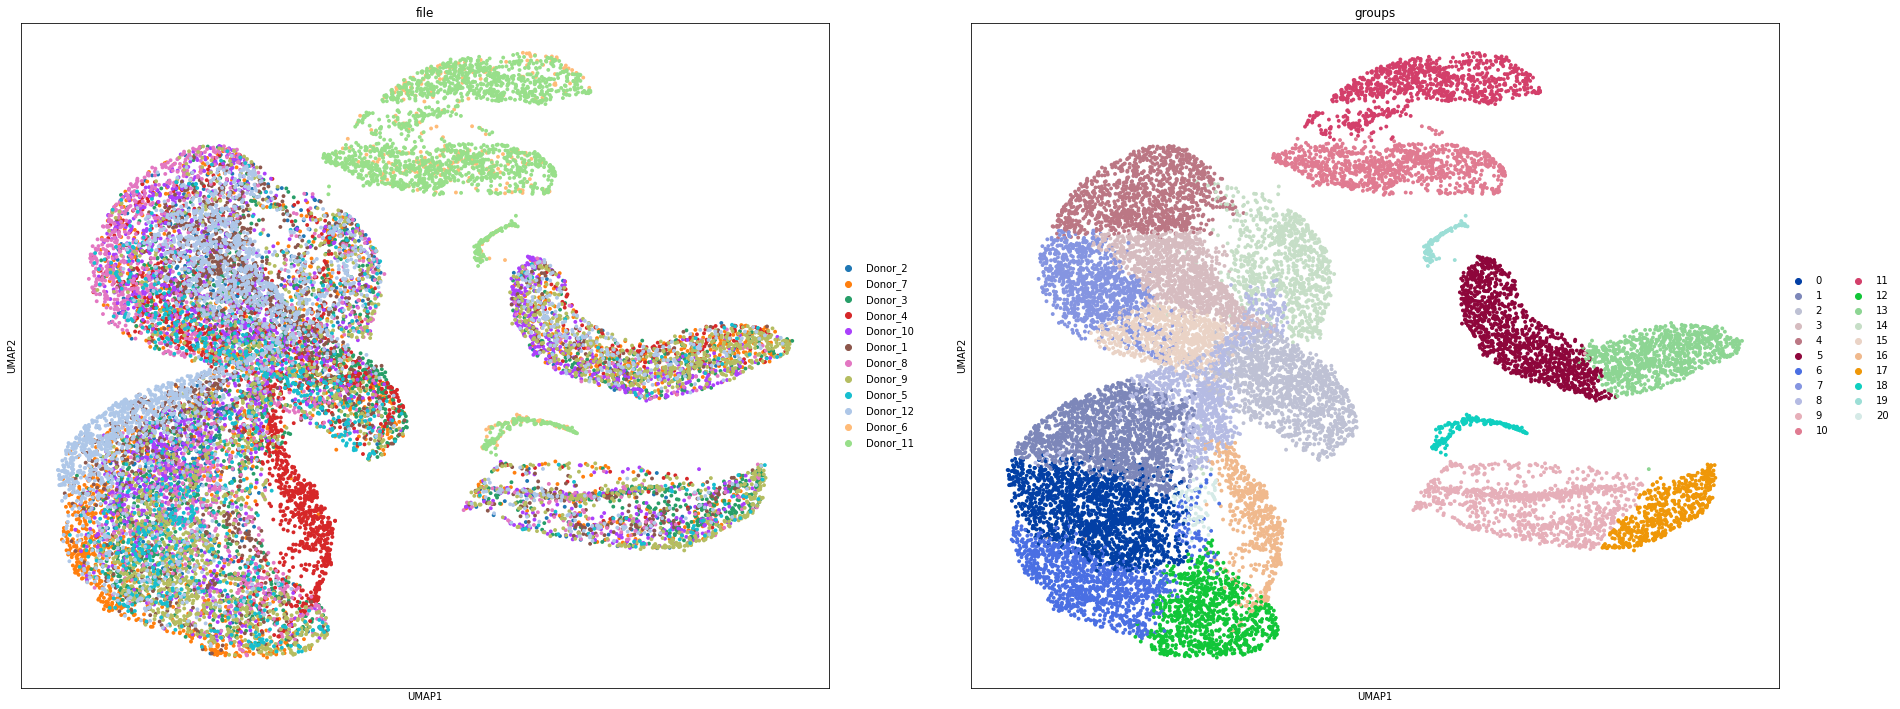

In [84]:
# Plot UMAP
rcParams['figure.figsize'] = (15, 12)
sc.pl.umap(adata_pp, color=['file','groups'], size=60)

Joint Scran normalisation

In [85]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [86]:
%%R -i data_mat -i input_groups -o size_factors
size_factors = calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1, BPPARAM=MulticoreParam(workers=8))

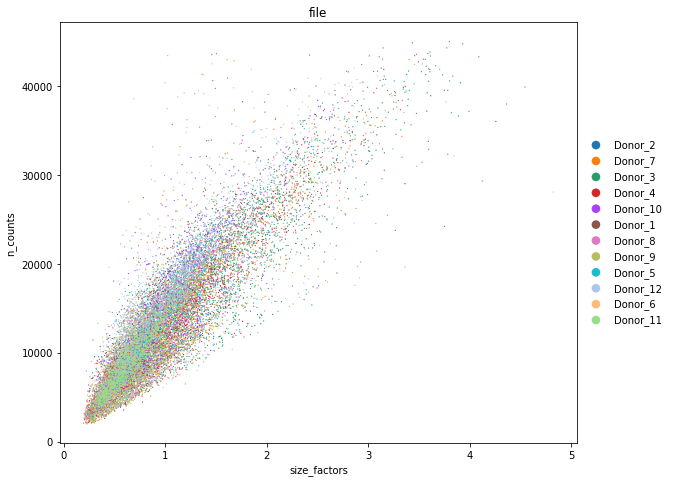

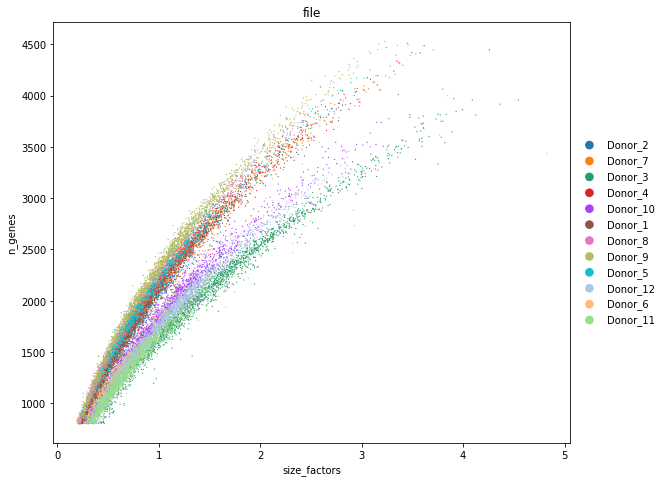

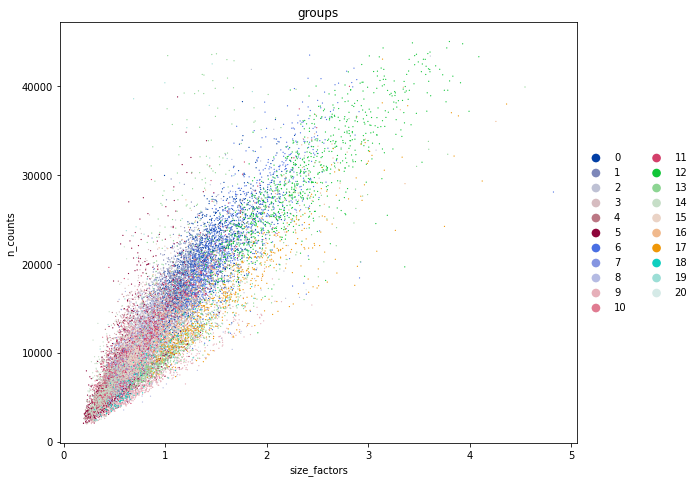

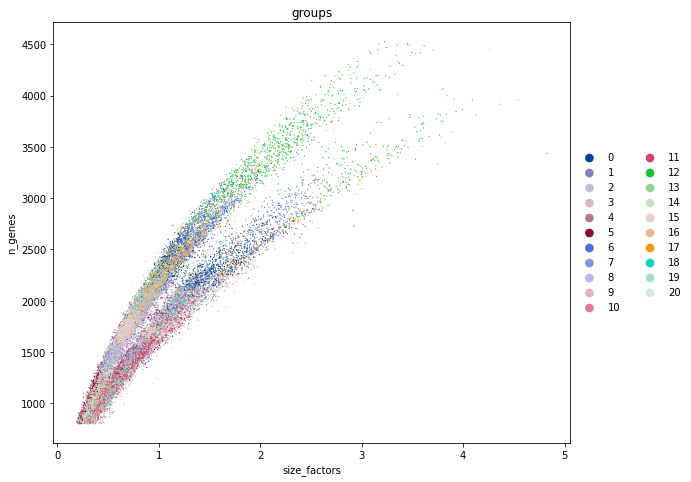

Distribution of size factors


/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


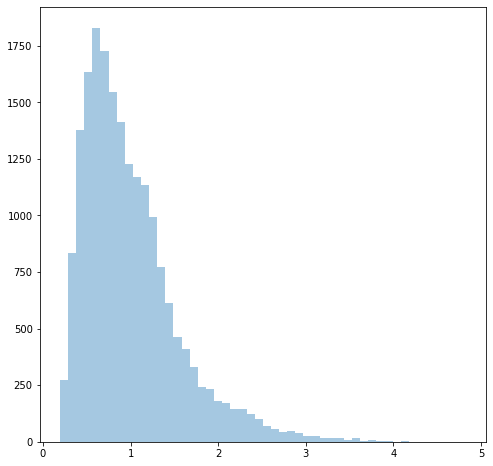

In [87]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, 'size_factors', 'n_counts', color='file')
sc.pl.scatter(adata, 'size_factors', 'n_genes', color='file')

#let us visualise how size factors differ across clusters
rcParams['figure.figsize'] = (8, 8)
#Use adata_pp here as it has obs 'group' - the n_genes and n_counts were copied from andata (counts/not normalised)
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

print('Distribution of size factors')
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [88]:
# Scale data with size factors
adata.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

In [89]:
del adata_pp

## Highly variable genes

Compare Seurat and CellRanger HVGs.

In [90]:
#hvg_vars=['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection']

## Seurat
#sc.pp.highly_variable_genes(adata, flavor='seurat', batch_key='file')
#n_hvg_seurat=np.sum(adata.var['highly_variable'])
#print('\n','Number of highly variable genes: {:d}'.format(n_hvg_seurat))
##hvg_seurat=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

## Same number of genes in CellRanger
#sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =n_hvg_seurat)
#print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
##hvg_cellranger=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

Decided for CellRanger method.

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/pyth

    finished (0:00:08)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.highly_variable.iloc[:n_top_genes] = True



 Number of highly variable genes: 2000


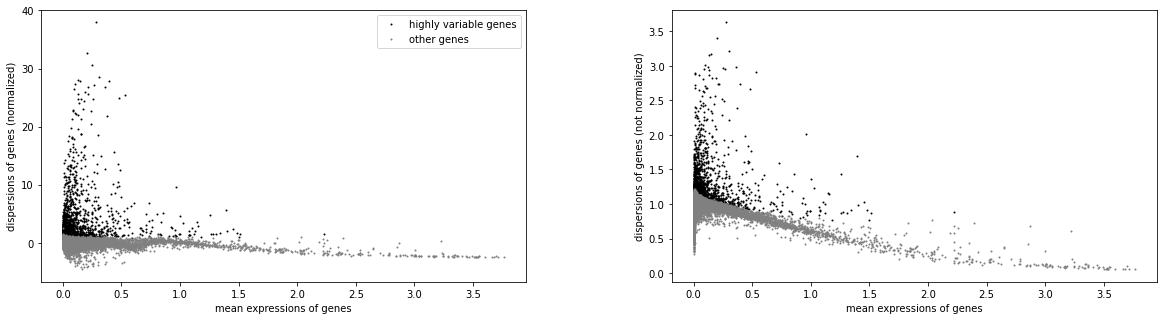

In [91]:
# Compute and plot HVG
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file', n_top_genes =2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
rcParams['figure.figsize'] = (10, 5)
sc.pl.highly_variable_genes(adata)

In [92]:
adata

AnnData object with n_obs × n_vars = 19499 × 15260
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter', 'n_genes_filter', 'mt_frac_filter', 'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'file_colors', 'n_counts_filter_colors', 'n_genes_filter_colors', 'mt_frac_filter_colors', 'doublet_score_filter_colors', 'log1p', 'hvg'
    layers: 'counts'

## Save normalised data

In [ ]:
# Used due to problems with saving h5ad
pickle.dump(adata, open(shared_folder + 'data_normalised.pkl', 'wb'))